## Snowflake Connection

In [1]:
from requests import ConnectionError
import requests
import json
from dateutil import tz
from dateutil.relativedelta import relativedelta
import datetime
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
import warnings
warnings.filterwarnings('ignore')
import time
import os
connection_timeout = 300
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
from tqdm.auto import tqdm
import snowflake.connector
from snowflake.connector import ProgrammingError
import pickle
from datetime import datetime, timedelta

In [2]:
def connect_to_snowflake():
    # Snowflake connection parameters
    conn_params = {
        'account': 'a206448_prod.us-east-1',
        'user': 'shivaraja.mc@thomsonreuters.com',
        'authenticator': 'externalbrowser',
        'warehouse': 'PROD_READONLY',
        'database': 'PROD',
        'schema': 'SOURCE',
        'role': 'TR_SHIVARAJA.MC@THOMSONREUTERS.COM',
        'client_session_keep_alive': True,
        'login_timeout': 60,  # Adjust the login timeout as needed
    }
    try:
        # Create a connection to Snowflake
        conn = snowflake.connector.connect(**conn_params)
        return conn
    except snowflake.connector.errors.ProgrammingError as e:
        print(f"Failed to connect to Snowflake: {e}")
        return None

def execute_query_and_return_dataframe(conn, query):
    try:
        # Execute the query and fetch into a pandas DataFrame
        df = pd.read_sql(query, conn)
        return df
    except Exception as e:
        print(f"An unexpected error occurred while fetching data into DataFrame: {e}")
        return None

# def main(sql,file_name):
#     conn = connect_to_snowflake()
#     if conn:
#         query = sql
#         df = execute_query_and_return_dataframe(conn, query)
#         if df is not None:
#             # Define your file path and name
#             file_path = r"C:\VO churn\\" + file_name  # Adjust path as necessary
#             # Save the DataFrame to CSV
#             df.to_csv(file_path, index=False)
#             print(f"DataFrame saved to {file_path}")
#         conn.close()

def main(sql):
    conn = connect_to_snowflake()
    if conn:
        df = execute_query_and_return_dataframe(conn, sql)
        conn.close()
        return df
    else:
        return None

## FirmStatus Code

In [3]:
query_firm_status = """
WITH LatestFirmUpdates AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY firm_id ORDER BY update_date DESC) AS rn
    FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
    WHERE product_code IN ('VOSET', 'SAAS')
)
SELECT *,
       CASE
           WHEN (license_expiration_date IS NULL OR license_expiration_date > GETDATE())
                AND (end_date IS NULL OR end_date > GETDATE())
           THEN 'Active'
           ELSE 'Cancelled'
       END AS status_flag
FROM LatestFirmUpdates
WHERE rn = 1;
"""

In [4]:
# Execute the main function and get the dataframe

df_firm_status = main(query_firm_status)

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLBjtowEIZfJXLPsZ0UEGsBqxS6KlpYIhKo2ktlEgMuiZ16HMK%2BfZ0A0vawe%2BjNGv8z38z8M3q8lIV3FgakVmMUYIo8oTKdS3UYo0365A%2BRB5arnBdaiTF6FYAeJyPgZVGxqLZHtRZ%2FagHWc4UUsPZjjGqjmOYggSleCmA2Y0m0XLAQU8YBhLEOh24pOUjHOlpbMUKapsHNZ6zNgYSUUkIfiFO1kk%2FoDaL6mFEZbXWmi3vKxc30DiIgtNcinMIR4lviF6muK%2FiIsruKgH1L09iPV0mKvOg%2B3VQrqEthEmHOMhOb9eLaALgOopAOer3hr3i9muEafMHB%2BgEGpZt9wU8i02VVW1cauxfZi5wU%2BiDdwuazMapOMg%2Be42X%2Ft9wGs6rc9aeXaJk8b6vFmZbw9Qevd7zZR9HL990mOGXI297tDVt75wC1mKvWVOtCNBz4NPTDfkr7LOwzOsQPA%2FoTeTNnqlTcdpn3zgE0tkddglZG1NYV7lqUeUWSZIVba0J0PQ%2FWgczkv4Yekbclbuf24hyYz2JdyOzVe9Km5PZ9gwIcdBGZ%2B%2FtOykTJZRHluREAzqii0M3UCG7dVVtTC0QmV%2Bq%2Fdz35Cw%3D%3D&RelayState=ver%3A3-hint%3A7475593022141094-ETMs

In [5]:
df_firm_status.head()

,FIRM_PRODUCT_VERSION_ID,FIRM_ID,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP,RN,STATUS_FLAG
0,10359025,449977,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,13627585,Leonard Woodall,1302,Non-Network,0,0,2016-12-28 12:06:00,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,2016-12-28 12:06:00,2017-01-04 12:06:00,NaT,0,518321,2026-02-09 13:15:07.297,GENCD,CS Professional Suite: Web Services,2014013519,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:25.819,2026-02-25 05:15:25.819,1,Cancelled
1,17507178,676366,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14940236,Whitney Richland,1302,Non-Network,0,0,2026-01-22 07:33:00,2026-01-22 07:33:00,NaT,NaT,2026-01-22 00:00:00,2026-04-30 00:00:00,2026-02-20,0,744491,2026-01-22 07:32:45.357,GENCD,CS Professional Suite: Web Services,2023702801,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:29.131,2026-02-25 05:15:29.131,1,Active
2,14857841,547515,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,13922410,Larry Hernandez,1302,Non-Network,0,0,2023-08-31 20:31:00,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,2023-08-31 00:00:00,2024-04-30 00:00:00,NaT,0,182724,2024-08-02 16:20:21.157,GENCD,CS Professional Suite: Web Services,2021460836,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:07:36.734,2026-02-25 05:07:36.734,1,Cancelled
3,15602069,669646,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14827698,Geri Bohn,1302,Non-Network,0,0,2024-05-20 13:14:00,2024-05-20 13:14:00,NaT,NaT,2024-05-20 13:14:00,2024-05-27 13:14:00,NaT,0,11729,2024-07-05 09:57:29.397,GENCD,CS Professional Suite: Web Services,2022088522,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:45.112,2026-02-25 05:15:45.112,1,Active
4,11379946,625514,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14329631,Mike Schaefbauer,1302,Non-Network,0,0,2018-08-30 11:28:00,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,2018-08-30 11:28:00,2018-09-06 11:28:00,NaT,0,81369,2021-01-16 14:14:07.493,GENCD,CS Professional Suite: Web Services,2016031525,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:29.131,2026-02-25 05:15:29.131,1,Cancelled


In [6]:
df_firm_status.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)

## Flash Support Ticket Query

In [7]:
query_ticket = """
WITH Support_Tickets AS (
    SELECT DISTINCT
        DATE(b.STARTDATETIME) AS TICKET_START_DATE,
        DATE(b.CLOSEDDATETIME) AS TICKET_CLOSE_DATE,
        DATEDIFF(DAY, b.STARTDATETIME, b.CLOSEDDATETIME) AS ticket_time,
        a.TICKETID,
        b.FIRMID,
        a.CONTACTNAME,
        CONCAT(TRIM(b.FIRMID), TRIM(b.PRODUCTCODE)) AS FIRM_PRODUCT,
        CASE 
            WHEN b.TICKETCATEGORY = 'P' THEN 'Support'
            WHEN b.TICKETCATEGORY = 'C' THEN 'Customer Service'
            WHEN b.TICKETCATEGORY = 'B' THEN 'Bug'
            WHEN b.TICKETCATEGORY = 'L' THEN 'Lead'
            ELSE 'Unknown'
        END AS TICKETCATEGORY,
        TRIM(c.TOPICDESCRIPTION) AS TOPICDESCRIPTION,
        CASE 
            WHEN b.TICKETSTATUS = 'C' THEN 'Closed'
            WHEN b.TICKETSTATUS = 'V' THEN 'Void'
            WHEN b.TICKETSTATUS = 'O' THEN 'Open'
            ELSE 'Unknown'
        END AS TICKETSTATUS
    FROM PROD.SOURCE.FLASH_DBO_TICKETACTIVITY_VW a
    INNER JOIN PROD.SOURCE.FLASH_DBO_TICKET_VW b ON TRIM(a.TICKETID) = TRIM(b.TICKETID)
    INNER JOIN PROD.SOURCE.FLASH_DBO_TOPIC_VW c ON TRIM(b.TOPICCODE) = TRIM(c.TOPICCODE)
    WHERE TRIM(b.PRODUCTCODE) IN ('VOSET', 'SAAS')  -- Improved WHERE clause
    ORDER BY a.CONTACTNAME
)

SELECT 
    FIRMID,
    COUNT(DISTINCT CASE WHEN TICKETSTATUS = 'Closed' THEN TICKETID END) AS CLOSED_COUNT,
    COUNT(DISTINCT CASE WHEN TICKETSTATUS = 'Open' THEN TICKETID END) AS OPEN_COUNT,
    COUNT(DISTINCT CASE WHEN TICKETSTATUS = 'Void' THEN TICKETID END) AS VOID_COUNT,
    COUNT(DISTINCT CASE WHEN TICKETSTATUS = 'Unknown' THEN TICKETID END) AS UNKNOWN_COUNT
FROM Support_Tickets
GROUP BY FIRMID
ORDER BY FIRMID;
 """

In [8]:
# Execute the main function and get the dataframe

df_ticket = main(query_ticket)

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNc9owEIb%2Fikc9WxKuTRINkHGgFGaS4GLoIZeOagujYktGK8chv74yHzPJITnkplm9u8%2Fuvju4falK71kYkFoNUQ9T5AmV6VyqYojWq6l%2FjTywXOW81EoM0UEAuh0NgFdlzeLGbtVS7BsB1nOFFLDuY4gao5jmIIEpXglgNmNp%2FHDPAkwZBxDGOhw6p%2BQgHWtrbc0IadsWt9%2BxNgUJKKWE3hCn6iTf0BtE%2FTmjNtrqTJeXlBc30weIHqFhh3AKR0jOiXdSnVbwGeXvSQRstlolfrJIV8iLL9ONtYKmEiYV5llmYr28PzUAroM4oP0wvP6TLBcT3IAvOFi%2Fh0HpdlPynch0VTfWlcbuRTYiJ6UupFvYfDJE9U7mlZz%2BaH%2B9rqPo31wWapbv95ufs2myWD%2FMiuKG72ZP8q4%2FPrxetRnyfl%2FsDTp75wCNmKvOVOtCNOj7NPCDaEUjFkQsvMJh1H9C3sSZKhW3x8xL5wAa262uQCsjGusKH1uUeU3SdIE7awJ0Og92BJnRl4YekLclzuf26ByYTxJdyuzgTbWpuP3YoB7uHSMy9zdHKRMVl2Wc50YAOKPKUrdjI7h1V21NIxAZnajv73r0Hw%3D%3D&RelayState=ver%3A3-hint%3A7475593022141094-ETMsDgAA

In [9]:
df_ticket.head()

,FIRMID,CLOSED_COUNT,OPEN_COUNT,VOID_COUNT,UNKNOWN_COUNT
0,154,4,0,0,0
1,241,0,0,1,0
2,300,0,0,1,0
3,407,1,0,1,0
4,494,0,0,1,0


In [10]:
df_ticket.rename(columns={'FIRMID' : 'firm_id'}, inplace = True)

## Flash Call Support Query 

In [11]:

query_call = """
WITH Calls AS (
    SELECT DISTINCT
        DATE(a.CALLSTARTDATETIME) AS CALLSTARTDATE,
        a.CALLID,
        a.FIRMID,
        a.PRODUCTCODE,  -- Added missing comma here
        CONCAT(TRIM(a.FIRMID), TRIM(a.PRODUCTCODE)) AS FIRM_PRODUCT,
        CASE 
            WHEN a.TICKETCATEGORY = 'P' THEN 'Support'
            WHEN a.TICKETCATEGORY = 'C' THEN 'Customer Service'
            WHEN a.TICKETCATEGORY = 'B' THEN 'Bug'
            WHEN a.TICKETCATEGORY = 'L' THEN 'Lead'
            ELSE 'Unknown'
        END AS TICKETCATEGORY,
        CASE 
            WHEN a.ACTIVITYTYPE = 'I' THEN 'Incoming Call'
            WHEN a.ACTIVITYTYPE = 'O' THEN 'Outgoing Call'
            WHEN a.ACTIVITYTYPE = 'D' THEN 'Email Prospecting'
            WHEN a.ACTIVITYTYPE = 'M' THEN 'Email Response'
            WHEN a.ACTIVITYTYPE = 'P' THEN 'Proactive'
            ELSE 'Others'
        END AS ACTIVITYTYPE,
        a.CALLMINUTES
    FROM PROD.SOURCE.FLASH_DBO_CALL_VW a
    WHERE TRIM(a.PRODUCTCODE) IN ('VOSET', 'SAAS')
)

SELECT 
    FIRMID,
    COUNT(DISTINCT CALLID) AS distinct_call_count,
    ROUND(AVG(CALLMINUTES), 2) AS avg_call_minutes,
    SUM(CALLMINUTES) AS total_call_minutes,
    -- Pivoted TICKETCATEGORY columns
    COUNT(CASE WHEN TICKETCATEGORY = 'Support' THEN CALLID END) AS Support_calls,
    COUNT(CASE WHEN TICKETCATEGORY = 'Customer Service' THEN CALLID END) AS Customer_Service_calls,
    COUNT(CASE WHEN TICKETCATEGORY = 'Bug' THEN CALLID END) AS Bug_calls,
    COUNT(CASE WHEN TICKETCATEGORY = 'Lead' THEN CALLID END) AS Lead_calls,
    COUNT(CASE WHEN TICKETCATEGORY = 'Unknown' THEN CALLID END) AS Unknown_calls
    
FROM Calls
GROUP BY FIRMID 
ORDER BY FIRMID;
"""

In [12]:
# Execute the main function and get the dataframe

df_call = main(query_call)

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb9swDIb%2FiqGdLcluHDRCksJtkNVbu3j52LpeBtVWEiGy5Ipy3ezXT84H0B3aw24C9ZIPyZfDq9dKBS%2FCgjR6hCJMUSB0YUqpNyO0Wk7DSxSA47rkymgxQnsB6Go8BF6pmqWN2%2Bq5eG4EuMAX0sC6jxFqrGaGgwSmeSWAuYIt0vs7FmPKOICwzuPQKaUE6Vlb52pGSNu2uL3Axm5ITCkldEC8qpN8Qm8Q9ceM2hpnCqPOKa9%2BpncQEaG9DuEVnpCfEq%2BlPq7gI8rTUQTsdrnMw3y2WKIgPU93YzQ0lbALYV9kIVbzu2MD4DtIY9rv9S5%2F5%2FPZBDcQCg4ujDBo064V34nCVHXjfGnsX2QtSqLMRvqFZZMRqneynP5Knr9Hbavyz09J%2BnVtkvzigQ4eXLZ5nN7ur3%2F2yz%2FZl2q12e0KFPw42xt39mYAjch0Z6rzIRr3QxqHcbKkCYsTlvTxYHD5iIKJN1Vq7g6Z584BDHZbU4HRVjTOFz60KMuaLBYz3FkTo%2BN5sAPIjv9r6CF5W%2BJ0bt%2B8A9kkN0oW%2B2BqbMXd%2BwZFODpEZBmuD1ImKi5VWpZWAHijlDLtjRXc%2Bat2thGIjI%2FUf%2B96%2FBc%3D&RelayState=ver%3A3-hint%3A747559302214109

In [13]:
df_call.head()

,FIRMID,DISTINCT_CALL_COUNT,AVG_CALL_MINUTES,TOTAL_CALL_MINUTES,SUPPORT_CALLS,CUSTOMER_SERVICE_CALLS,BUG_CALLS,LEAD_CALLS,UNKNOWN_CALLS
0,154,4,17.0,68,4,0,0,0,0
1,241,1,2.0,2,1,0,0,0,0
2,300,1,1.0,1,1,0,0,0,0
3,407,2,16.5,33,1,1,0,0,0
4,494,1,1.0,1,0,1,0,0,0


In [14]:
df_call.rename(columns={'FIRMID' : 'firm_id'}, inplace = True)

In [15]:
# # Function to rename columns by appending the DataFrame name
# def rename_columns(df, df_name):
#     return df.rename(columns=lambda x: f"{df_name}_{x}" if x != 'firm_id' else x)

# # Function to convert firm_id column to string
# def convert_firm_id_to_string(df):
#     if 'firm_id' in df.columns:
#         df['firm_id'] = df['firm_id'].astype(str)
#     return df

# # Convert firm_id to string in all DataFrames
# df_firm_status = convert_firm_id_to_string(df_firm_status)
# df_ticket = convert_firm_id_to_string(df_ticket)
# df_call = convert_firm_id_to_string(df_call)
# metrics_df = convert_firm_id_to_string(metrics_df)

In [16]:
# # Perform left joins using both firm_id and product_code
# df_firm = df_firm_status \
#     .merge(df_ticket, on=['firm_id', 'PRODUCT_CODE'], how='left') \
#     .merge(df_call, on=['firm_id', 'PRODUCT_CODE'], how='left') \
#     # .merge(metrics_df, on=['firm_id'], how='left')

In [17]:

def clean_join_keys(df, has_product_code=True):
    df = df.copy()
    # Always clean firm_id
    if df['firm_id'].dtype == 'object':
        df['firm_id'] = df['firm_id'].astype(str).str.strip()
    else:
        # Convert numeric firm_id to string for consistency
        df['firm_id'] = df['firm_id'].astype(str).str.strip()
    
    # Only clean PRODUCT_CODE if it exists
    if has_product_code and 'PRODUCT_CODE' in df.columns:
        if df['PRODUCT_CODE'].dtype == 'object':
            df['PRODUCT_CODE'] = df['PRODUCT_CODE'].astype(str).str.strip().str.upper()
    
    return df

# Clean all dataframes
df_firm_status_clean = clean_join_keys(df_firm_status)
df_ticket_clean = clean_join_keys(df_ticket)
df_call_clean = clean_join_keys(df_call)


# Try the join again
df_firm = df_firm_status_clean \
    .merge(df_ticket_clean, on=['firm_id'], how='left') \
    .merge(df_call_clean, on=['firm_id'], how='left') \
    

In [18]:
df_firm.head()

,FIRM_PRODUCT_VERSION_ID,firm_id,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP,RN,STATUS_FLAG,CLOSED_COUNT,OPEN_COUNT,VOID_COUNT,UNKNOWN_COUNT,DISTINCT_CALL_COUNT,AVG_CALL_MINUTES,TOTAL_CALL_MINUTES,SUPPORT_CALLS,CUSTOMER_SERVICE_CALLS,BUG_CALLS,LEAD_CALLS,UNKNOWN_CALLS
0,10359025,449977,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,13627585,Leonard Woodall,1302,Non-Network,0,0,2016-12-28 12:06:00,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,2016-12-28 12:06:00,2017-01-04 12:06:00,NaT,0,518321,2026-02-09 13:15:07.297,GENCD,CS Professional Suite: Web Services,2014013519,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:25.819,2026-02-25 05:15:25.819,1,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17507178,676366,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14940236,Whitney Richland,1302,Non-Network,0,0,2026-01-22 07:33:00,2026-01-22 07:33:00,NaT,NaT,2026-01-22 00:00:00,2026-04-30 00:00:00,2026-02-20,0,744491,2026-01-22 07:32:45.357,GENCD,CS Professional Suite: Web Services,2023702801,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:29.131,2026-02-25 05:15:29.131,1,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14857841,547515,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,13922410,Larry Hernandez,1302,Non-Network,0,0,2023-08-31 20:31:00,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,2023-08-31 00:00:00,2024-04-30 00:00:00,NaT,0,182724,2024-08-02 16:20:21.157,GENCD,CS Professional Suite: Web Services,2021460836,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:07:36.734,2026-02-25 05:07:36.734,1,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15602069,669646,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14827698,Geri Bohn,1302,Non-Network,0,0,2024-05-20 13:14:00,2024-05-20 13:14:00,NaT,NaT,2024-05-20 13:14:00,2024-05-27 13:14:00,NaT,0,11729,2024-07-05 09:57:29.397,GENCD,CS Professional Suite: Web Services,2022088522,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:45.112,2026-02-25 05:15:45.112,1,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11379946,625514,1843,VOSET,Virtual Office CS Setup,.263.265.268.1843.,34593,1.0.0,2800,Current,1276,Annual renew,14329631,Mike Schaefbauer,1302,Non-Network,0,0,2018-08-30 11:28:00,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,2018-08-30 11:28:00,2018-09-06 11:28:00,NaT,0,81369,2021-01-16 14:14:07.493,GENCD,CS Professional Suite: Web Services,2016031525,0,2026-02-25 04:49:09.019,EMS,2026-02-25 05:15:29.131,2026-02-25 05:15:29.131,1,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_firm.shape

(13368, 50)

In [20]:
# Dropping columns

df_dropped = df_firm.drop(columns = ['FIRM_PRODUCT_VERSION_ID', 'PRODUCT_ID', 'PRODUCT_HIERARCHY', 'PRODUCT_VERSION_ID', 'VERSION', 'PRODUCT_VERSION_STATUS_OL', 'PRODUCT_VERSION_STATUS', 'LICENSE_TYPE_OL', 'LICENSE_TYPE', 'LICENSEE__FIRM_CONTACT_ID', 'LICENSEE', 'NETWORK_TYPE_OL', 'NETWORK_TYPE', 'UNITS', 'BEGIN_DATE', 'FREE_SUPPORT_BEGIN_DATE', 'FREE_SUPPORT_END_DATE', 'FINANCE_EXPIRATION_DATE', 'IS_NO_LONGER_USING', 'UPDATE__EMS_USER_ID', 'UPDATE_DATE', 'CD__PRODUCT_CODE', 'PRODUCT_FAMILY', 'ORDER_DETAIL_ID', 'CDO_LOAD_TIMESTAMP', 'EDL_LOAD_TIMESTAMP', 'RN', ])

In [21]:
df_dropped.head()

,firm_id,PRODUCT_CODE,PRODUCT_NAME,SEATS,PURCHASE_DATE,END_DATE,LICENSE_EXPIRATION_DATE,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,STATUS_FLAG,CLOSED_COUNT,OPEN_COUNT,VOID_COUNT,UNKNOWN_COUNT,DISTINCT_CALL_COUNT,AVG_CALL_MINUTES,TOTAL_CALL_MINUTES,SUPPORT_CALLS,CUSTOMER_SERVICE_CALLS,BUG_CALLS,LEAD_CALLS,UNKNOWN_CALLS
0,449977,VOSET,Virtual Office CS Setup,0,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,676366,VOSET,Virtual Office CS Setup,0,2026-01-22 07:33:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547515,VOSET,Virtual Office CS Setup,0,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,669646,VOSET,Virtual Office CS Setup,0,2024-05-20 13:14:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,625514,VOSET,Virtual Office CS Setup,0,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_dropped.isnull().sum()

firm_id                        0
PRODUCT_CODE                   0
PRODUCT_NAME                   0
SEATS                          0
PURCHASE_DATE                  0
END_DATE                    7271
LICENSE_EXPIRATION_DATE    13333
ALLOW_QUANTITY                 0
INSERT_TIMESTAMP               0
DATA_PROVIDER_NAME             0
STATUS_FLAG                    0
CLOSED_COUNT                8562
OPEN_COUNT                  8562
VOID_COUNT                  8562
UNKNOWN_COUNT               8562
DISTINCT_CALL_COUNT         8586
AVG_CALL_MINUTES            8586
TOTAL_CALL_MINUTES          8586
SUPPORT_CALLS               8586
CUSTOMER_SERVICE_CALLS      8586
BUG_CALLS                   8586
LEAD_CALLS                  8586
UNKNOWN_CALLS               8586
dtype: int64

In [23]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   firm_id                  13368 non-null  object        
 1   PRODUCT_CODE             13368 non-null  object        
 2   PRODUCT_NAME             13368 non-null  object        
 3   SEATS                    13368 non-null  int64         
 4   PURCHASE_DATE            13368 non-null  datetime64[ns]
 5   END_DATE                 6097 non-null   datetime64[ns]
 6   LICENSE_EXPIRATION_DATE  35 non-null     datetime64[ns]
 7   ALLOW_QUANTITY           13368 non-null  int64         
 8   INSERT_TIMESTAMP         13368 non-null  datetime64[ns]
 9   DATA_PROVIDER_NAME       13368 non-null  object        
 10  STATUS_FLAG              13368 non-null  object        
 11  CLOSED_COUNT             4806 non-null   float64       
 12  OPEN_COUNT               4806 no

In [24]:
df_dropped.columns.str.lower()

Index(['firm_id', 'product_code', 'product_name', 'seats', 'purchase_date',
       'end_date', 'license_expiration_date', 'allow_quantity',
       'insert_timestamp', 'data_provider_name', 'status_flag', 'closed_count',
       'open_count', 'void_count', 'unknown_count', 'distinct_call_count',
       'avg_call_minutes', 'total_call_minutes', 'support_calls',
       'customer_service_calls', 'bug_calls', 'lead_calls', 'unknown_calls'],
      dtype='object')

In [31]:
# Convert column names to lowercase (assign back to dataframe)
df_dropped.columns = df_dropped.columns.str.lower()

# Then export to CSV
df_dropped.to_csv(r'C:\Users\6130665\All Codes\VO Churn Predection\VOCHURN_NEW\\VO_firms_support_25_02_2026.csv', index=False)

# EMS connection

In [32]:
def connect_to_ems(query, database_name):
    """
    Connects to a SQL Server database using SQLAlchemy and SQL Server Authentication,
    executes the given SQL query, and returns the result as a pandas DataFrame.

    Args:
        query (str): The SQL query string to execute.

    Returns:
        pandas.DataFrame: A DataFrame containing the query results, or None if an error occurs.
    """
    # Connection parameters provided by the user
    # IMPORTANT: Ensure 'ODBC Driver 17 for SQL Server' or the appropriate version
    # is installed on your system.
    server = 'egmissqlprod3.int.thomsonreuters.com,1600'  # include port number if applicable
    database = database_name  # adjust this to your database name
   

    # Create the connection URL for SQLAlchemy using SQL Server Authentication
    # 'mssql+pyodbc://' specifies the dialect and driver.
    # 'username:password@server:port/database' specifies authentication details.
    # '?driver=ODBC+Driver+17+for+SQL+Server' specifies the ODBC driver.
    # Note: Trusted_Connection=yes is removed as we are now using username/password.
    connection_url = (
        "mssql+pyodbc://"
        f"{server}/{database}"
        "?driver=ODBC+Driver+17+for+SQL+Server&Trusted_Connection=yes"
    )

    try:
        print(f"Attempting to connect to: {server}/{database}")
        # Create the SQLAlchemy engine
        engine = create_engine(connection_url)

        # Confirm the connection by attempting to connect
        with engine.connect() as connection:
            print("✅ Connected to the database successfully!")

        # Execute the query and load data into a DataFrame
        # pd.read_sql is used with the SQLAlchemy engine
        df = pd.read_sql(query, engine)
        return df

    except Exception as e:
        print(f"❌ Error occurred: {e}")
        print("Please ensure:")
        print("1. 'ODBC Driver 17 for SQL Server' is installed.")
        print("2. The username and password are correct and have access to the database.")
        print("3. The server name and database name are correct.")
        print("4. Network connectivity to the SQL Server is established and the port is open.")
        return None

# Web Login data

In [33]:
query_web_service_login = """
SELECT 
    wsa.firm_ID,
    COUNT(DISTINCT wsu.login) AS [Login count]
FROM 
    EMS_Copy.dbo.Web_Service_Activity_User wsau
    JOIN EMS_Copy.dbo.Web_Service_Activity_view wsa ON wsau.web_service_activity_ID = wsa.web_service_activity_ID
    JOIN EMS_Copy.dbo.Web_Service_User wsu ON wsau.web_service_user_ID = wsu.web_service_user_ID
WHERE 
   wsa.product_code IN ('VOSET', 'SAAS')
GROUP BY 
   wsa.firm_ID;
"""

In [34]:
df_login = connect_to_ems(query_web_service_login, 'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [35]:
df_login.head()

,firm_ID,Login count


In [36]:
df_login = df_login.rename(columns = {'firm_ID' : 'firm_id'})

# Web service client

In [37]:
query_web_service_client = """
SELECT 
    parent__firm_id,
    COUNT(web_service_client_id) AS web_service_total_clients
FROM 
    [EMS_Copy].[dbo].[Web_Service_Client]
GROUP BY 
    parent__firm_id;
"""

In [38]:
df_web_service_client = connect_to_ems(query_web_service_client,'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [40]:
df_web_service_client = df_web_service_client.rename(columns = {'parent__firm_id' : 'firm_id'})

In [41]:
df_web_service_client.head()

,firm_id,web_service_total_clients
0,64268,128
1,453931,435
2,491140,1
3,440200,10
4,513361,20


# Web Service SAAS firm

In [42]:
query_web_service_saas_firm = """
SELECT 
  firm_ID,
  COUNT(web_service_SaaS_firm_ID) AS total_saas_services_purchased,
  CASE WHEN MAX(CASE WHEN VO_begin_date IS NOT NULL THEN 1 ELSE 0 END) = 1 THEN 1 ELSE 0 END AS is_VO_to_SAAS_transition
FROM EMS_Copy.dbo.Web_Service_SaaS_Firm
GROUP BY firm_ID;
"""

In [43]:
df_web_service_saas_firm = connect_to_ems(query_web_service_saas_firm,'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [44]:
df_web_service_saas_firm = df_web_service_saas_firm.rename(columns = {'firm_ID' : 'firm_id'})

In [45]:
df_web_service_saas_firm.head()

,firm_id,total_saas_services_purchased,is_VO_to_SAAS_transition
0,0,1,0
1,60355,1,1
2,30640,1,0
3,287877,1,0
4,290748,1,0


# Web service cancellation

In [46]:
query_web_service_cancellation = """
WITH LatestUpdates AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY firm_ID ORDER BY update_date DESC) AS rn
    FROM [EMS_Copy].[dbo].[Web_Service_Cancellation]
)
SELECT 
    wc.firm_ID,
    COUNT(wc.web_service_cancellation_ID) AS total_web_cancellations,
    cancel.description AS cancel_reason_description
FROM 
    LatestUpdates wc
JOIN 
    [EMS_Copy].[dbo].[Web_Service_Group] wg ON wc.web_service_group_ID = wg.web_service_group_ID
LEFT JOIN 
    [EMS_Copy].[dbo].[Option_List] vo ON wc.web_service_loss_reason_OL = vo.option_list_ID 
LEFT JOIN 
    [EMS_Copy].[dbo].[Option_List] cancel ON wc.web_service_loss_reason_OL = cancel.option_list_ID 
WHERE 
    wc.rn = 1
GROUP BY 
    wc.firm_ID, cancel.description;
"""

In [47]:
df_web_service_cancellation = connect_to_ems(query_web_service_cancellation,'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [48]:
df_web_service_cancellation = df_web_service_cancellation.rename(columns = {'firm_ID' : 'firm_id'})

In [49]:
df_web_service_cancellation.head()

,firm_id,total_web_cancellations,cancel_reason_description
0,0,1,
1,328,1,
2,791,1,
3,961,1,
4,3858,1,


# Web service activity SQL

In [50]:
query_web_service_activity_sql = """
SELECT 
    firm_ID,
    COUNT(web_service_activity_ID) AS total_web_activities,
    SUM(quantity) AS total_web_quantity,
    SUM(retail_price) AS total_web_retail_price,
    SUM(discount_amount) AS total_web_discount_amount,
    SUM(fee) AS total_web_fee,
    SUM(retail_fee) AS total_web_retail_fee
FROM 
    [EMS_Copy].[dbo].[Web_Service_Activity]
GROUP BY 
    firm_ID;
"""

In [51]:
df_web_service_activity_sql = connect_to_ems(query_web_service_activity_sql,'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [52]:
df_web_service_activity_sql = df_web_service_activity_sql.rename(columns = {'firm_ID' : 'firm_id'})

In [53]:
df_web_service_activity_sql.head()

,firm_id,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee
0,7826,158,265,10562.9,0.0,15579.00,14804.90
1,60355,1044,3371,127550.2,4891.0,134445.20,135723.20
2,30640,558,752,111502.6,0.0,118324.44,118324.44
3,452010,544,565,106059.6,762.0,105513.60,106266.60
4,582538,74,13405,4007.0,0.0,5936.00,3845.00


# Price SQL

In [ ]:
# query_price_sql = """
# select f.firm_id, COUNT(o.order_id) AS total_orders, 
# SUM(od.retail_price) AS total_retail_price,
# SUM(odt.discount_amount) AS total_discount_amount
# from ems_copy..firm f
# left join ems_copy..[order] o on o.firm_id = f.firm_id
# left join ems_Copy..order_Detail od on od.order_id = o.order_id
# left join  EMS_Copy..order_detail_transaction odt on odt.order_Detail_id = od.order_detail_id
# GROUP BY f.firm_ID;
# """

In [ ]:
# df_price_sql = connect_to_ems(query_price_sql,'EMS_Copy')

In [ ]:
# df_price_sql = df_price_sql.rename(columns = {'firm_ID' : 'firm_id'})

In [ ]:
# df_price_sql.head()

# Web sevice order

In [54]:
query_web_service_order = """
SELECT 
    firm_ID,    
    COUNT(web_service_order_ID) AS web_service_total_orders,
    SUM(quantity) AS web_service_total_quantity,
    SUM(amount) AS web_service_total_order_value,
    ROUND(AVG(amount),0) AS web_service_average_order_value
FROM 
    [EMS_Copy].[dbo].[Web_Service_Order]
WHERE 
    product_code IN ('VOSET', 'SAAS')
GROUP BY 
    firm_ID;
"""

In [55]:
df_web_service_order = connect_to_ems(query_web_service_order,'EMS_Copy')

Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [56]:
df_web_service_order = df_web_service_order.rename(columns = {'firm_ID' : 'firm_id'})

In [57]:
df_web_service_order.head()

,firm_id,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value
0,282922,29,34,16255.00,561.0
1,561622,5,16,6313.01,1263.0
2,203572,178,271,147400.98,828.0
3,82459,157,415,216538.56,1379.0
4,631463,86,94,65390.94,760.0


# Merging into a single dataframe

In [77]:
# Function to rename columns by appending the DataFrame name
def rename_columns(df, df_name):
    return df.rename(columns=lambda x: f"{df_name}_{x}" if x != 'firm_id' else x)

# Function to convert firm_id column to string
def convert_firm_id_to_string(df):
    if 'firm_id' in df.columns:
        df['firm_id'] = df['firm_id'].astype(str)
    return df

# Convert firm_id to string in all DataFrames
df_dropped= convert_firm_id_to_string(df_dropped) 
df_login = convert_firm_id_to_string(df_login)
df_web_service_client = convert_firm_id_to_string(df_web_service_client)
df_web_service_saas_firm = convert_firm_id_to_string(df_web_service_saas_firm)
df_web_service_cancellation = convert_firm_id_to_string(df_web_service_cancellation)
df_web_service_activity_sql = convert_firm_id_to_string(df_web_service_activity_sql)
df_web_service_order = convert_firm_id_to_string(df_web_service_order)


In [78]:
# Perform left joins
df_final = df_dropped \
    .merge(df_web_service_activity_sql, on=['firm_id'], how='left') \
    .merge(df_login, on=['firm_id'], how='left') \
    .merge(df_web_service_client, on='firm_id', how='left') \
    .merge(df_web_service_saas_firm, on='firm_id', how='left') \
    .merge(df_web_service_cancellation, on='firm_id', how='left') \
    .merge(df_web_service_order, on=['firm_id'], how='left')

# This will result in:
# - Each firm will have multiple rows (one for each product_code: SAAS, VOSET)
# - Firm-level data will be duplicated across product codes for the same firm
    
    

In [79]:
df_final.head()

,firm_id,product_code,product_name,seats,purchase_date,end_date,license_expiration_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,total_web_cancellations,cancel_reason_description,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value
0,449977,VOSET,Virtual Office CS Setup,0,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.0,15095.0,52809.3,0.0,354306.92,361509.5,NaN,1.0,1.0,0.0,1.0,Cost,59.0,363.0,131007.4,2220.0
1,676366,VOSET,Virtual Office CS Setup,0,2026-01-22 07:33:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,163.0,0.0,163.00,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547515,VOSET,Virtual Office CS Setup,0,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.0,1629.0,0.0,147.00,1629.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN
3,669646,VOSET,Virtual Office CS Setup,0,2024-05-20 13:14:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,84.0,3303.0,0.0,6606.00,6606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,625514,VOSET,Virtual Office CS Setup,0,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,4163.0,0.0,2977.97,4163.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN


In [80]:
df_final.shape

(13368, 39)

In [81]:
df_final.to_excel(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Backup files\VO_churn_data_25_02_2026.xlsx', index = False)

In [82]:
df_final_columns = df_final 

In [83]:
df_final_columns.head()

,firm_id,product_code,product_name,seats,purchase_date,end_date,license_expiration_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,total_web_cancellations,cancel_reason_description,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value
0,449977,VOSET,Virtual Office CS Setup,0,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.0,15095.0,52809.3,0.0,354306.92,361509.5,NaN,1.0,1.0,0.0,1.0,Cost,59.0,363.0,131007.4,2220.0
1,676366,VOSET,Virtual Office CS Setup,0,2026-01-22 07:33:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,163.0,0.0,163.00,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547515,VOSET,Virtual Office CS Setup,0,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.0,1629.0,0.0,147.00,1629.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN
3,669646,VOSET,Virtual Office CS Setup,0,2024-05-20 13:14:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,84.0,3303.0,0.0,6606.00,6606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,625514,VOSET,Virtual Office CS Setup,0,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,4163.0,0.0,2977.97,4163.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN


In [84]:
df_final_columns.isnull().sum()

firm_id                                0
product_code                           0
product_name                           0
seats                                  0
purchase_date                          0
end_date                            7271
license_expiration_date            13333
allow_quantity                         0
insert_timestamp                       0
data_provider_name                     0
status_flag                            0
closed_count                        8562
open_count                          8562
void_count                          8562
unknown_count                       8562
distinct_call_count                 8586
avg_call_minutes                    8586
total_call_minutes                  8586
support_calls                       8586
customer_service_calls              8586
bug_calls                           8586
lead_calls                          8586
unknown_calls                       8586
total_web_activities                 485
total_web_quanti

In [85]:
df_final_columns.head()

,firm_id,product_code,product_name,seats,purchase_date,end_date,license_expiration_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,total_web_cancellations,cancel_reason_description,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value
0,449977,VOSET,Virtual Office CS Setup,0,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.0,15095.0,52809.3,0.0,354306.92,361509.5,NaN,1.0,1.0,0.0,1.0,Cost,59.0,363.0,131007.4,2220.0
1,676366,VOSET,Virtual Office CS Setup,0,2026-01-22 07:33:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,163.0,0.0,163.00,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547515,VOSET,Virtual Office CS Setup,0,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.0,1629.0,0.0,147.00,1629.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN
3,669646,VOSET,Virtual Office CS Setup,0,2024-05-20 13:14:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,84.0,3303.0,0.0,6606.00,6606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,625514,VOSET,Virtual Office CS Setup,0,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,4163.0,0.0,2977.97,4163.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN


df_final_columns--webservice data
df_resukts--ADO Ticket data

In [86]:
# Step 1: Get unique firm IDs from df_dropped (ADO Ticket data)
unique_firmids_from_flash = df_dropped['firm_id'].unique()
print(f"Unique FIRM IDs in Flash data: {len(unique_firmids_from_flash)}")

# Step 2: Filter df_final_columns (Excel data) to keep only records with firm IDs that exist in df_dropped
filtered_excel_data = df_final_columns[df_final_columns['firm_id'].isin(unique_firmids_from_flash)].copy()

# Step 3: Display results
print(f"Original Excel data records: {len(df_final_columns)}")
print(f"Filtered Excel data records: {len(filtered_excel_data)}")
print(f"Unique FIRM IDs in filtered data: {filtered_excel_data['firm_id'].nunique()}")

# Show the filtered data

filtered_excel_data.head()

Unique FIRM IDs in Flash data: 13368
Original Excel data records: 13368
Filtered Excel data records: 13368
Unique FIRM IDs in filtered data: 13368


,firm_id,product_code,product_name,seats,purchase_date,end_date,license_expiration_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,total_web_cancellations,cancel_reason_description,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value
0,449977,VOSET,Virtual Office CS Setup,0,2016-12-28 12:06:00,2026-01-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,657.0,15095.0,52809.3,0.0,354306.92,361509.5,NaN,1.0,1.0,0.0,1.0,Cost,59.0,363.0,131007.4,2220.0
1,676366,VOSET,Virtual Office CS Setup,0,2026-01-22 07:33:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,163.0,0.0,163.00,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,547515,VOSET,Virtual Office CS Setup,0,2023-08-31 20:31:00,2024-07-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.0,1629.0,0.0,147.00,1629.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN
3,669646,VOSET,Virtual Office CS Setup,0,2024-05-20 13:14:00,NaT,NaT,0,2026-02-25 04:49:09.019,EMS,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,84.0,3303.0,0.0,6606.00,6606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,625514,VOSET,Virtual Office CS Setup,0,2018-08-30 11:28:00,2020-12-31 23:59:00,NaT,0,2026-02-25 04:49:09.019,EMS,Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,4163.0,0.0,2977.97,4163.0,NaN,NaN,NaN,NaN,1.0,Cost,NaN,NaN,NaN,NaN


In [87]:
filtered_excel_data.to_excel(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Backup files\VO_churn_filtered_excel_data_25_02_2026.xlsx', index = False)

In [88]:
combined_df = filtered_excel_data

In [89]:
combined_df.isnull().sum()

firm_id                                0
product_code                           0
product_name                           0
seats                                  0
purchase_date                          0
end_date                            7271
license_expiration_date            13333
allow_quantity                         0
insert_timestamp                       0
data_provider_name                     0
status_flag                            0
closed_count                        8562
open_count                          8562
void_count                          8562
unknown_count                       8562
distinct_call_count                 8586
avg_call_minutes                    8586
total_call_minutes                  8586
support_calls                       8586
customer_service_calls              8586
bug_calls                           8586
lead_calls                          8586
unknown_calls                       8586
total_web_activities                 485
total_web_quanti

In [90]:
import pandas as pd
from datetime import datetime

# Convert date columns to datetime
combined_df['purchase_date'] = pd.to_datetime(combined_df['purchase_date'], errors='coerce')
combined_df['end_date'] = pd.to_datetime(combined_df['end_date'], errors='coerce')

# Function to calculate duration
def calculate_duration_days(row):
    if row['status_flag'] == 'Active':
        duration_days = (datetime.now() - row['purchase_date']).days
    elif row['status_flag'] == 'Cancelled':
        duration_days = (row['end_date'] - row['purchase_date']).days
    else:
        return None
    
    return int(duration_days) if pd.notnull(duration_days) else None

# Apply the function
combined_df['subscription_duration_days'] = combined_df.apply(calculate_duration_days, axis=1)

# Filter for subscriptions with duration > 300 days
combined_df = combined_df[combined_df['subscription_duration_days'] > 300]

In [91]:
combined_df.isnull().sum()

firm_id                                0
product_code                           0
product_name                           0
seats                                  0
purchase_date                          0
end_date                            6657
license_expiration_date            11518
allow_quantity                         0
insert_timestamp                       0
data_provider_name                     0
status_flag                            0
closed_count                        7038
open_count                          7038
void_count                          7038
unknown_count                       7038
distinct_call_count                 7057
avg_call_minutes                    7057
total_call_minutes                  7057
support_calls                       7057
customer_service_calls              7057
bug_calls                           7057
lead_calls                          7057
unknown_calls                       7057
total_web_activities                 409
total_web_quanti

In [92]:
combined_df.drop(columns=['end_date', 'license_expiration_date', 'product_code', 'total_web_cancellations','cancel_reason_description' ], inplace=True)


In [93]:
# Define the fill values
fill_values = {
    'Login count': 0,
    'web_service_total_clients': 0,
    'total_saas_services_purchased ': 0,
    'total_web_discount_amount': 0,
    'total_web_fee': 0,
    'total_web_retail_fee': 0,
    'web_service_total_orders': 0,
    'web_service_total_quantity': 0,
    'web_service_total_order_value': 0,
    'web_service_average_order_value': 0,
    'total_saas_services_purchased': 0,
    'is_VO_to_SAAS_transition': 0,
    'ado_closed_count': 0,
    'closed_count': 0,
    'open_count': 0,
    'void_count': 0,
    'unknown_count': 0,
    'distinct_call_count': 0,
    'avg_call_minutes': 0,
    'total_call_minutes': 0,
    'support_calls': 0,
    'customer_service_calls': 0,
    'bug_calls': 0,
    'lead_calls': 0,
    'unknown_calls': 0,
    'ado_total_customer_impacts': 0,
    'ado_average_duration': 0,
    'ado_severity_mode': 0,
    'total_web_activities': 0,
    'total_web_quantity': 0,
    'total_web_retail_price': 0,
    'subscription_duration_days' : 0
}

# Fill missing values
combined_df.fillna(value=fill_values, inplace=True)


In [94]:
combined_df.isnull().sum()

firm_id                            0
product_name                       0
seats                              0
purchase_date                      0
allow_quantity                     0
insert_timestamp                   0
data_provider_name                 0
status_flag                        0
closed_count                       0
open_count                         0
void_count                         0
unknown_count                      0
distinct_call_count                0
avg_call_minutes                   0
total_call_minutes                 0
support_calls                      0
customer_service_calls             0
bug_calls                          0
lead_calls                         0
unknown_calls                      0
total_web_activities               0
total_web_quantity                 0
total_web_retail_price             0
total_web_discount_amount          0
total_web_fee                      0
total_web_retail_fee               0
Login count                        0
w

In [95]:
duplicate_count = combined_df.duplicated(subset='firm_id', keep=False).sum()


In [96]:
print(f"Number of duplicate records based on 'firm_id': {duplicate_count}")


Number of duplicate records based on 'firm_id': 0


In [97]:
# Find duplicate records based on 'firm_id'
duplicates = combined_df[combined_df.duplicated(subset='firm_id', keep=False)]

In [98]:
# Identify columns with differing values within each firm_id group
diff_columns = []
for col in combined_df.columns:
    if col != 'firm_id':
        if duplicates.groupby('firm_id')[col].nunique().gt(1).any():
            diff_columns.append(col)

# Output the columns causing duplicates
print("Columns causing duplicate records for firm_id:")
print(diff_columns)

Columns causing duplicate records for firm_id:
[]


In [99]:
combined_df['subscription_duration_days'] = combined_df['subscription_duration_days'].abs()

In [100]:
combined_df['status_flag'].value_counts()

status_flag
Active       6657
Cancelled    4884
Name: count, dtype: int64

In [101]:
# Extract columns with dtype as int and calculate correlation
int_columns_corr = combined_df.select_dtypes(include=['int64', 'int32', 'float32', 'float64']).corr()

# Set a threshold for high correlation
threshold = 0.8

# Find pairs of highly correlated columns
highly_correlated = []
for i in range(len(int_columns_corr.columns)):
    for j in range(i):
        if abs(int_columns_corr.iloc[i, j]) > threshold:
            colname = int_columns_corr.columns[i]
            rowname = int_columns_corr.index[j]
            correlation = int_columns_corr.iloc[i, j] * 100  # Convert to percentage
            highly_correlated.append((rowname, colname, correlation))

# Convert to DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated, columns=['Column 1', 'Column 2', 'Correlation Percentage'])
highly_correlated_df

,Column 1,Column 2,Correlation Percentage
0,closed_count,distinct_call_count,96.321392
1,closed_count,total_call_minutes,93.035306
2,distinct_call_count,total_call_minutes,92.606287
3,closed_count,support_calls,95.723999
4,distinct_call_count,support_calls,99.089502
5,total_call_minutes,support_calls,92.483760
6,total_web_activities,total_web_retail_price,85.536928
7,total_web_fee,total_web_retail_fee,96.864384
8,total_web_retail_price,web_service_total_orders,85.497058
9,total_web_retail_price,web_service_total_order_value,80.149332


In [102]:
combined_df.head()

,firm_id,product_name,seats,purchase_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days
0,449977,Virtual Office CS Setup,0,2016-12-28 12:06:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,15095.0,52809.3,0.0,354306.92,361509.5,0,1.0,1.0,0.0,59.0,363.0,131007.4,2220.0,3321.0
2,547515,Virtual Office CS Setup,0,2023-08-31 20:31:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,1629.0,0.0,147.00,1629.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335.0
3,669646,Virtual Office CS Setup,0,2024-05-20 13:14:00,0,2026-02-25 04:49:09.019,EMS,Active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,84.0,3303.0,0.0,6606.00,6606.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,646.0
4,625514,Virtual Office CS Setup,0,2018-08-30 11:28:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,56.0,4163.0,0.0,2977.97,4163.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.0
5,34890,Virtual Office CS Setup,0,2017-02-16 14:35:00,0,2026-02-25 04:49:09.019,EMS,Active,0.0,0.0,1.0,0.0,1.0,37.0,37.0,1.0,0.0,0.0,0.0,0.0,691.0,20750.0,31437.2,0.0,32441.20,31378.2,0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,3296.0


## encoding categorical columns

In [103]:
from sklearn.preprocessing import LabelEncoder

In [104]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

In [105]:
combined_df['firm_status_encoded'] = label_encoder.fit_transform(combined_df['status_flag'])

In [106]:
combined_df.head()

,firm_id,product_name,seats,purchase_date,allow_quantity,insert_timestamp,data_provider_name,status_flag,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days,firm_status_encoded
0,449977,Virtual Office CS Setup,0,2016-12-28 12:06:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,15095.0,52809.3,0.0,354306.92,361509.5,0,1.0,1.0,0.0,59.0,363.0,131007.4,2220.0,3321.0,1
2,547515,Virtual Office CS Setup,0,2023-08-31 20:31:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,1629.0,0.0,147.00,1629.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335.0,1
3,669646,Virtual Office CS Setup,0,2024-05-20 13:14:00,0,2026-02-25 04:49:09.019,EMS,Active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,84.0,3303.0,0.0,6606.00,6606.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,646.0,0
4,625514,Virtual Office CS Setup,0,2018-08-30 11:28:00,0,2026-02-25 04:49:09.019,EMS,Cancelled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,56.0,4163.0,0.0,2977.97,4163.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.0,1
5,34890,Virtual Office CS Setup,0,2017-02-16 14:35:00,0,2026-02-25 04:49:09.019,EMS,Active,0.0,0.0,1.0,0.0,1.0,37.0,37.0,1.0,0.0,0.0,0.0,0.0,691.0,20750.0,31437.2,0.0,32441.20,31378.2,0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,3296.0,0


In [107]:
combined_df['firm_status_encoded'].value_counts()

firm_status_encoded
0    6657
1    4884
Name: count, dtype: int64

In [108]:
# # Perform one-hot encoding`
df_encoded = pd.get_dummies(combined_df, columns=[ 'product_name'])

In [109]:
columns_to_drop = [
'purchase_date', 'status_flag' , 'seats' , 'data_provider_name', 'insert_timestamp'
]

# Drop the columns
df_model = df_encoded.drop(columns=columns_to_drop)

In [110]:
df_model.head()

,firm_id,allow_quantity,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days,firm_status_encoded,product_name_Software as a Service (SaaS),product_name_Virtual Office CS Setup
0,449977,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,15095.0,52809.3,0.0,354306.92,361509.5,0,1.0,1.0,0.0,59.0,363.0,131007.4,2220.0,3321.0,1,False,True
2,547515,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,1629.0,0.0,147.00,1629.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335.0,1,False,True
3,669646,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,84.0,3303.0,0.0,6606.00,6606.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,646.0,0,False,True
4,625514,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,56.0,4163.0,0.0,2977.97,4163.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.0,1,False,True
5,34890,0,0.0,0.0,1.0,0.0,1.0,37.0,37.0,1.0,0.0,0.0,0.0,0.0,691.0,20750.0,31437.2,0.0,32441.20,31378.2,0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,3296.0,0,False,True


In [111]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11541 entries, 0 to 13367
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   firm_id                                    11541 non-null  object 
 1   allow_quantity                             11541 non-null  int64  
 2   closed_count                               11541 non-null  float64
 3   open_count                                 11541 non-null  float64
 4   void_count                                 11541 non-null  float64
 5   unknown_count                              11541 non-null  float64
 6   distinct_call_count                        11541 non-null  float64
 7   avg_call_minutes                           11541 non-null  float64
 8   total_call_minutes                         11541 non-null  float64
 9   support_calls                              11541 non-null  float64
 10  customer_service_calls     

In [112]:
# converting bool columns to int
df_model[df_model.select_dtypes(include=[bool]).columns] = df_model.select_dtypes(include=[bool]).astype(int)

In [113]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11541 entries, 0 to 13367
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   firm_id                                    11541 non-null  object 
 1   allow_quantity                             11541 non-null  int64  
 2   closed_count                               11541 non-null  float64
 3   open_count                                 11541 non-null  float64
 4   void_count                                 11541 non-null  float64
 5   unknown_count                              11541 non-null  float64
 6   distinct_call_count                        11541 non-null  float64
 7   avg_call_minutes                           11541 non-null  float64
 8   total_call_minutes                         11541 non-null  float64
 9   support_calls                              11541 non-null  float64
 10  customer_service_calls     

In [114]:
# Checking correlation with firm_status_encoded

plt.figure(figsize=(14,7))
df_model.corr()['firm_status_encoded'].sort_values(ascending = False)

firm_status_encoded                          1.000000
total_saas_services_purchased                0.101713
product_name_Software as a Service (SaaS)    0.070740
is_VO_to_SAAS_transition                     0.030590
web_service_average_order_value             -0.002399
web_service_total_clients                   -0.005110
unknown_count                               -0.006527
total_web_quantity                          -0.019758
lead_calls                                  -0.029445
open_count                                  -0.033346
total_web_discount_amount                   -0.034300
unknown_calls                               -0.045915
void_count                                  -0.046463
bug_calls                                   -0.059093
product_name_Virtual Office CS Setup        -0.070740
web_service_total_quantity                  -0.087269
customer_service_calls                      -0.097096
firm_id                                     -0.113842
web_service_total_orders    

<Figure size 1400x700 with 0 Axes>

In [115]:
df_model.to_excel(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Backup files\VO_churn_model_Final_data.xlsx')

In [116]:
df_model.head()

,firm_id,allow_quantity,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days,firm_status_encoded,product_name_Software as a Service (SaaS),product_name_Virtual Office CS Setup
0,449977,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,15095.0,52809.3,0.0,354306.92,361509.5,0,1.0,1.0,0.0,59.0,363.0,131007.4,2220.0,3321.0,1,0,1
2,547515,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,1629.0,0.0,147.00,1629.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335.0,1,0,1
3,669646,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,84.0,3303.0,0.0,6606.00,6606.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,646.0,0,0,1
4,625514,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,56.0,4163.0,0.0,2977.97,4163.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.0,1,0,1
5,34890,0,0.0,0.0,1.0,0.0,1.0,37.0,37.0,1.0,0.0,0.0,0.0,0.0,691.0,20750.0,31437.2,0.0,32441.20,31378.2,0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,3296.0,0,0,1


In [117]:
# Putting feature variable to X
X = df_model.drop(['firm_status_encoded'], axis = 1)

# Putting response/target variable to y
y = df_model['firm_status_encoded']

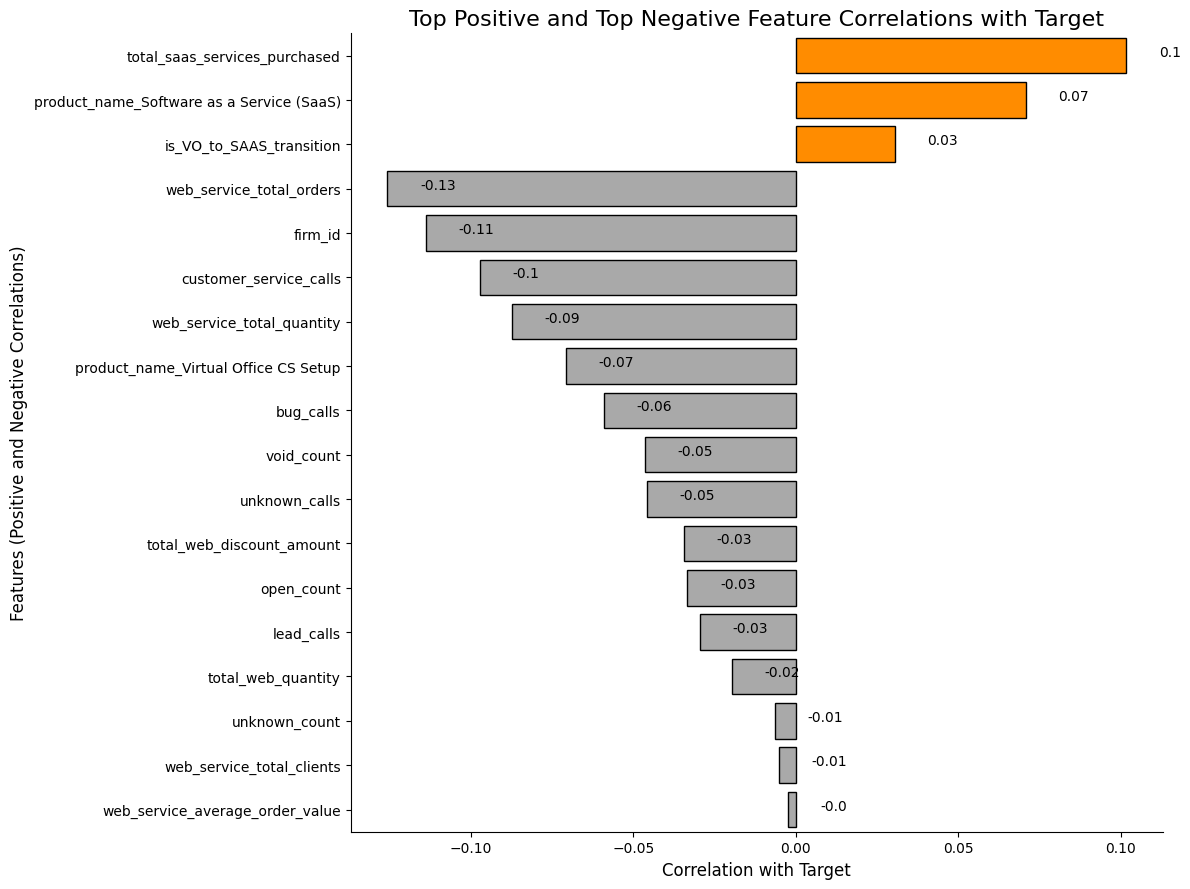

In [118]:
# Calculate the correlation between features and target variable
correlation_with_target = X.corrwith(y)

# Separate positive and negative correlations
positive_features = correlation_with_target[correlation_with_target > 0].sort_values(ascending=False)
negative_features = correlation_with_target[correlation_with_target <= 0].sort_values()

# Select the top 15 positive and negative correlations
top_positive_features = positive_features.head(15)
top_negative_features = negative_features.tail(15)

# Concatenate the positive and negative features
top_features = pd.concat([top_positive_features, top_negative_features])

# Create the index for the bar plot
index = np.arange(len(top_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot for top positive and negative correlations
feature_bar = ax.barh(index, top_features.values, color=['darkorange' if x > 0 else 'darkgrey' for x in top_features.values], edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_features.index)

# Add a gap between last positive and first negative correlation
ax.set_ylim([-0.5, len(top_features)-0.5])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_features.values):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add title and labels to the plot
plt.title("Top Positive and Top Negative Feature Correlations with Target", fontsize=16)
plt.xlabel("Correlation with Target", fontsize=12)
plt.ylabel("Features (Positive and Negative Correlations)", fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [119]:
# Machine learning libraries and functions:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.utils import class_weight

import statsmodels.api as sm

# Explainibility:

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import xgboost as xgb

from skopt import BayesSearchCV

In [120]:
# Split churned and active firms
churned_firms = df_model[df_model["firm_status_encoded"] == 1]
active_firms = df_model[df_model["firm_status_encoded"] == 0]

In [121]:
# Hold out 30% of active firms for prediction
active_train, active_holdout = train_test_split(active_firms, test_size=0.3, random_state=42)

In [122]:
# Combine churned firms + 70% active firms for training
training_data = pd.concat([churned_firms, active_train])

In [123]:
# Features and target
X = training_data.drop(columns=["firm_id", "firm_status_encoded"])
y = training_data["firm_status_encoded"]

In [124]:
# Splitting the data into train and test: 80-20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state= 42)

In [125]:
def plot_confusion_matrix(y_test, pred_test):
    cm = confusion_matrix(y_test, pred_test)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Set2)
    classNames = ['Active-Subscription','Lapsed-Subscription']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
    plt.show()

In [126]:
active_train.columns

Index(['firm_id', 'allow_quantity', 'closed_count', 'open_count', 'void_count',
       'unknown_count', 'distinct_call_count', 'avg_call_minutes',
       'total_call_minutes', 'support_calls', 'customer_service_calls',
       'bug_calls', 'lead_calls', 'unknown_calls', 'total_web_activities',
       'total_web_quantity', 'total_web_retail_price',
       'total_web_discount_amount', 'total_web_fee', 'total_web_retail_fee',
       'Login count', 'web_service_total_clients',
       'total_saas_services_purchased', 'is_VO_to_SAAS_transition',
       'web_service_total_orders', 'web_service_total_quantity',
       'web_service_total_order_value', 'web_service_average_order_value',
       'subscription_duration_days', 'firm_status_encoded',
       'product_name_Software as a Service (SaaS)',
       'product_name_Virtual Office CS Setup'],
      dtype='object')

## XGBoost - Bayesian optimization - scoring on Precision

In [127]:
from requests import ConnectionError
import requests
import json
from dateutil import tz
from dateutil.relativedelta import relativedelta
import datetime
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
import warnings
warnings.filterwarnings('ignore')
import time
import os
connection_timeout = 300
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
from tqdm.auto import tqdm
import snowflake.connector
from snowflake.connector import ProgrammingError
import pickle
from datetime import datetime, timedelta

# Machine learning libraries and functions:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.utils import class_weight

import statsmodels.api as sm

# Explainibility:

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import xgboost as xgb

from skopt import BayesSearchCV

In [128]:
# Create the XGBoost classifier
xgb_clf_Precision = xgb.XGBClassifier(random_state=42)

In [129]:
# Define the search space for hyperparameters
param_space = {
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 180, 200],
    'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
}

# Create the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_clf_Precision,
    search_spaces=param_space,
    scoring='precision',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      feature_weights=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=No...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='precision',
              search_spaces={'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
                             'learning_rate': [0.01, 0.1, 0.2, 0.3],
                             'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100,
                                           120, 140, 160],
                             'n_estimators': [5, 10, 20, 50, 80, 100, 120, 150,
                                              180, 200],
                             'subsample': [0.5, 0.7, 0.8, 1.0]})

In [130]:
# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

print("Best parameters:", best_params)
print("Best precision score:", best_score)

Best parameters: OrderedDict({'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 160, 'n_estimators': 80, 'subsample': 0.8})
Best precision score: 0.8323552760487128


In [131]:
# Get the best estimator from the BayesSearchCV object
best_estimator_xgboost_precision = bayes_cv.best_estimator_

# Evaluating on Training set`
y_pred_train = best_estimator_xgboost_precision.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

print(confusion_matrix(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3758
           1       1.00      1.00      1.00      3876

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634

Train Accuracy: 0.9986900707361802
[[3757    1]
 [   9 3867]]


In [132]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_xgboost_precision.predict_proba(X_test)[:, 1]

In [133]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

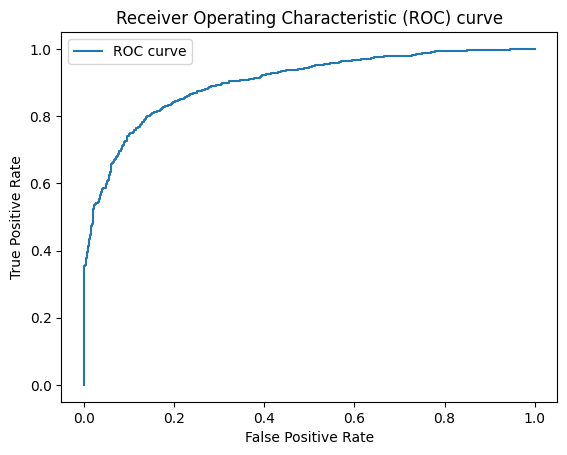

In [134]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()

In [135]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)

AUC score: 0.9011812272078642


In [136]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)

Optimal Cutoff point: 0.5612633


In [137]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

In [138]:
# Evaluating on Test set

print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       901
           1       0.87      0.80      0.83      1008

    accuracy                           0.83      1909
   macro avg       0.83      0.83      0.83      1909
weighted avg       0.83      0.83      0.83      1909

Test Accuracy: 0.83


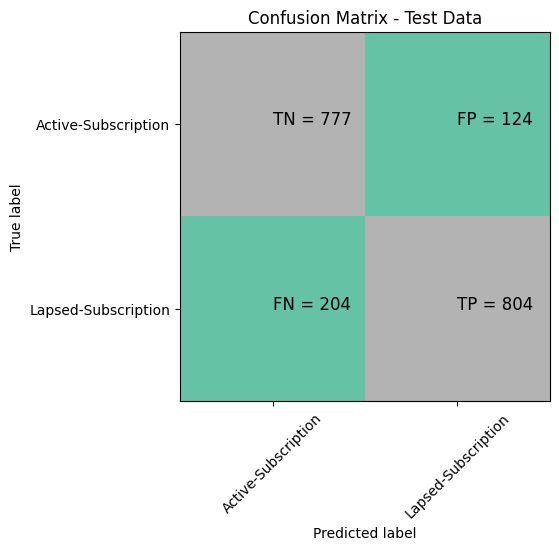

In [139]:
plot_confusion_matrix(y_test, y_pred_optimal)

XGBoost roc_value: 0.83
XGBoost threshold: 1.0
ROC for the test dataset 83.0%


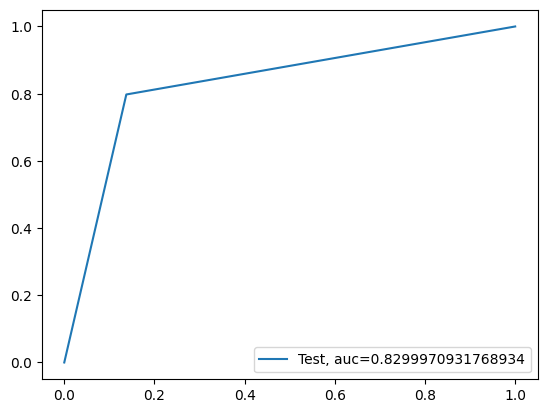

In [140]:
l2_roc_value = round(roc_auc_score(y_test, y_pred_optimal),2)
print("XGBoost roc_value: {0}".format(l2_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

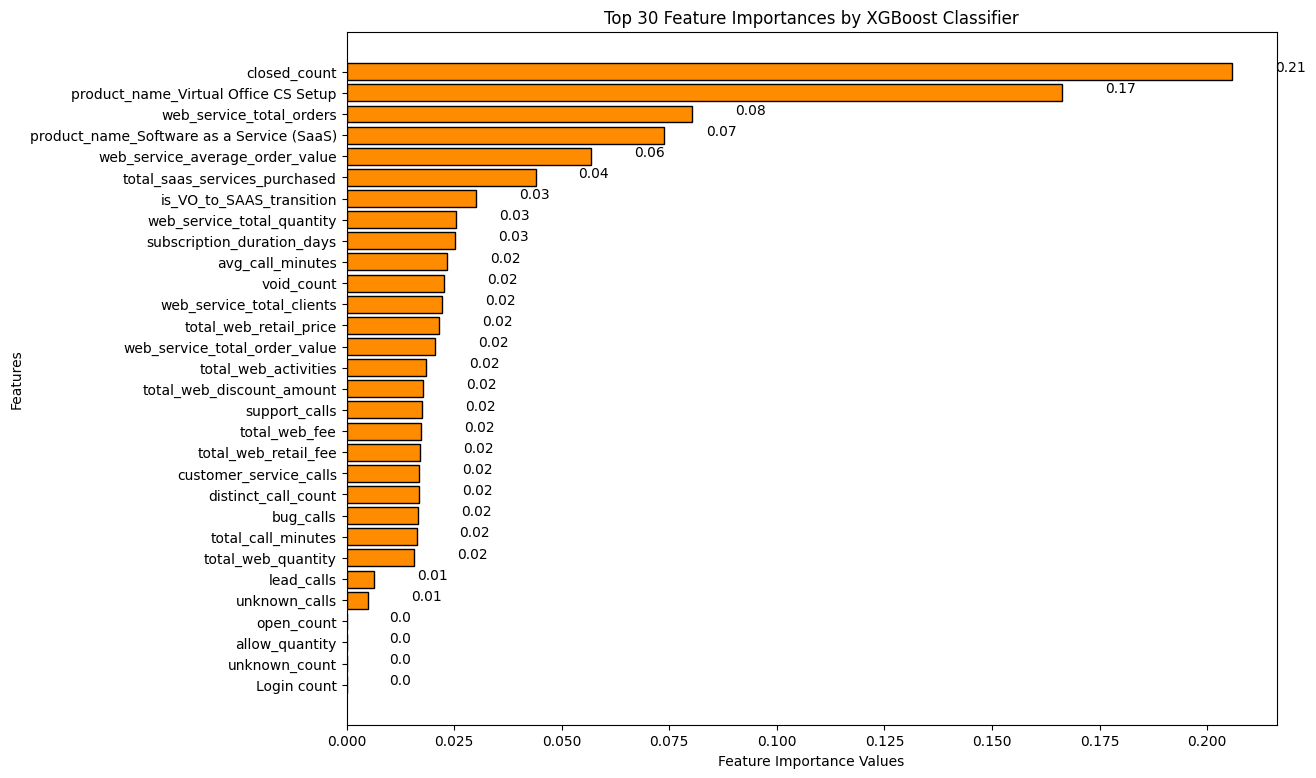

In [141]:
# Get the feature importances from the XGBoost classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_xgboost_precision.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by XGBoost Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()

In [142]:
import shap

In [143]:
#Compute SHAP values for XGBoost on precision
explainer_xg_precision = shap.Explainer(best_estimator_xgboost_precision)
shap_values_xg_precision = explainer_xg_precision(X_test)

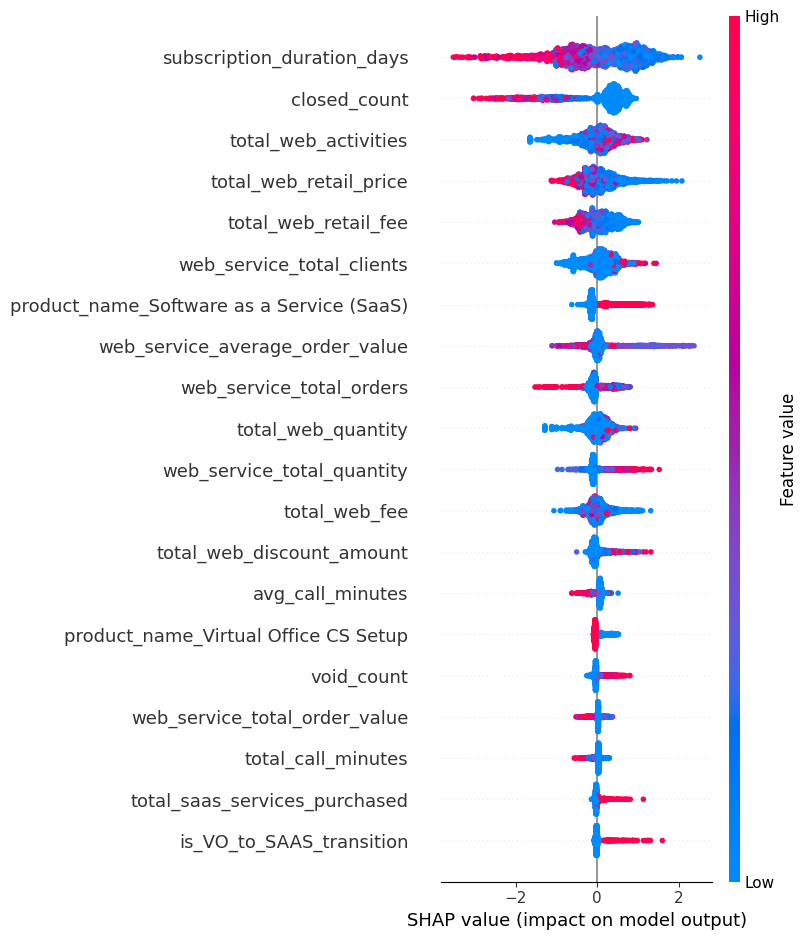

In [144]:
# Create a summary plot for the combined SHAP values
shap.summary_plot(shap_values_xg_precision, X_test)

## Data preprocessing for predicting churn on new dataset

In [145]:
active_holdout.head()

,firm_id,allow_quantity,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days,firm_status_encoded,product_name_Software as a Service (SaaS),product_name_Virtual Office CS Setup
6760,440106,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,316.0,3148.0,1615.16,0.0,1615.16,1615.16,0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,3521.0,0,0,1
467,287012,0,1.0,0.0,0.0,0.0,1.0,7.00,7.0,1.0,0.0,0.0,0.0,0.0,347.0,781.0,47467.60,0.0,108107.30,107917.30,0,21.0,1.0,0.0,52.0,151.0,100849.3,1939.0,1573.0,0,1,0
9525,629490,0,1.0,0.0,0.0,0.0,1.0,39.00,39.0,1.0,0.0,0.0,0.0,0.0,194.0,849.0,16490.50,153.0,35881.40,66408.40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2630.0,0,0,1
5952,669348,0,4.0,0.0,0.0,0.0,4.0,20.25,81.0,4.0,0.0,0.0,0.0,0.0,87.0,276.0,18253.00,0.0,20227.00,20227.00,0,0.0,1.0,0.0,22.0,22.0,18034.0,820.0,678.0,0,1,0
3198,661817,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,87.0,211.0,6685.20,0.0,2799.00,16196.40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1282.0,0,0,1


In [146]:
active_holdout.columns

Index(['firm_id', 'allow_quantity', 'closed_count', 'open_count', 'void_count',
       'unknown_count', 'distinct_call_count', 'avg_call_minutes',
       'total_call_minutes', 'support_calls', 'customer_service_calls',
       'bug_calls', 'lead_calls', 'unknown_calls', 'total_web_activities',
       'total_web_quantity', 'total_web_retail_price',
       'total_web_discount_amount', 'total_web_fee', 'total_web_retail_fee',
       'Login count', 'web_service_total_clients',
       'total_saas_services_purchased', 'is_VO_to_SAAS_transition',
       'web_service_total_orders', 'web_service_total_quantity',
       'web_service_total_order_value', 'web_service_average_order_value',
       'subscription_duration_days', 'firm_status_encoded',
       'product_name_Software as a Service (SaaS)',
       'product_name_Virtual Office CS Setup'],
      dtype='object')

In [147]:
active_holdout.shape

(1998, 32)

In [148]:
# Putting feature variable to X
X_new = active_holdout.drop(['firm_status_encoded', "firm_id"], axis=1)

# Putting response/target variable to y
y_new = active_holdout['firm_status_encoded']

In [149]:
trained_columns = X_train.columns

In [150]:
prediction_columns = X_new.columns

In [151]:
missing_columns = [col for col in trained_columns if col not in prediction_columns]

In [152]:
for col in missing_columns:
    X_new[col] = 0

In [153]:
X_new = X_new[trained_columns]

In [154]:
X_new.head()

,allow_quantity,closed_count,open_count,void_count,unknown_count,distinct_call_count,avg_call_minutes,total_call_minutes,support_calls,customer_service_calls,bug_calls,lead_calls,unknown_calls,total_web_activities,total_web_quantity,total_web_retail_price,total_web_discount_amount,total_web_fee,total_web_retail_fee,Login count,web_service_total_clients,total_saas_services_purchased,is_VO_to_SAAS_transition,web_service_total_orders,web_service_total_quantity,web_service_total_order_value,web_service_average_order_value,subscription_duration_days,product_name_Software as a Service (SaaS),product_name_Virtual Office CS Setup
6760,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,316.0,3148.0,1615.16,0.0,1615.16,1615.16,0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,3521.0,0,1
467,0,1.0,0.0,0.0,0.0,1.0,7.00,7.0,1.0,0.0,0.0,0.0,0.0,347.0,781.0,47467.60,0.0,108107.30,107917.30,0,21.0,1.0,0.0,52.0,151.0,100849.3,1939.0,1573.0,1,0
9525,0,1.0,0.0,0.0,0.0,1.0,39.00,39.0,1.0,0.0,0.0,0.0,0.0,194.0,849.0,16490.50,153.0,35881.40,66408.40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2630.0,0,1
5952,0,4.0,0.0,0.0,0.0,4.0,20.25,81.0,4.0,0.0,0.0,0.0,0.0,87.0,276.0,18253.00,0.0,20227.00,20227.00,0,0.0,1.0,0.0,22.0,22.0,18034.0,820.0,678.0,1,0
3198,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,87.0,211.0,6685.20,0.0,2799.00,16196.40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1282.0,0,1


In [155]:
y_probs_new = best_estimator_xgboost_precision.predict_proba(X_new)[:,1]

In [156]:
optimal_threshold

np.float32(0.5612633)

In [157]:
#Apply the cut off threshold
cutoff_threshold = optimal_threshold

In [158]:
y_pred_new =(y_probs_new >= cutoff_threshold).astype(int)

In [159]:
print(y_pred_new)

[0 0 0 ... 0 1 0]


In [160]:
# Print the probabilities and binary predictions
for i, prob in enumerate(y_probs_new):
    print(f"Record {i+1}: Probability = {prob:.2f}, Prediction = {y_pred_new[i]}")

Record 1: Probability = 0.01, Prediction = 0
Record 2: Probability = 0.38, Prediction = 0
Record 3: Probability = 0.03, Prediction = 0
Record 4: Probability = 0.05, Prediction = 0
Record 5: Probability = 0.16, Prediction = 0
Record 6: Probability = 0.01, Prediction = 0
Record 7: Probability = 0.01, Prediction = 0
Record 8: Probability = 0.09, Prediction = 0
Record 9: Probability = 0.02, Prediction = 0
Record 10: Probability = 0.02, Prediction = 0
Record 11: Probability = 0.84, Prediction = 1
Record 12: Probability = 0.07, Prediction = 0
Record 13: Probability = 0.18, Prediction = 0
Record 14: Probability = 0.00, Prediction = 0
Record 15: Probability = 0.11, Prediction = 0
Record 16: Probability = 0.89, Prediction = 1
Record 17: Probability = 0.00, Prediction = 0
Record 18: Probability = 0.09, Prediction = 0
Record 19: Probability = 0.04, Prediction = 0
Record 20: Probability = 0.13, Prediction = 0
Record 21: Probability = 0.04, Prediction = 0
Record 22: Probability = 0.02, Prediction =

In [161]:
# Create a DataFrame with the probabilities and predictions
results_df = pd.DataFrame({
    'firm_id': active_holdout['firm_id'],
    'churn_probability': y_probs_new,
    'model_prediction': y_pred_new
})

In [162]:
# Merge the results with the original DataFrame on Account_ID
final_result_VO_churn = pd.merge(active_holdout, results_df, on='firm_id')

In [ ]:
# Final result
final_result_VO_churn.to_excel(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Phase 2 results\VO_churn_probability_February_result_set.xlsx', index = False)

## below 2 query results should be vlookup with the final results set

### Query to identify firm product subscriptions (VOSET, SAAS, VOUTAX) 

In [164]:

query_voutax = """
WITH LatestFirmUpdates AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY firm_id ORDER BY update_date DESC) AS rn
    FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
    WHERE product_code IN ('VOSET', 'SAAS', 'VOUTAX')
),

FirmProductFlags AS (
    SELECT firm_id,
           MAX(CASE WHEN product_code = 'VOSET' THEN 1 ELSE 0 END) AS has_voset,
           MAX(CASE WHEN product_code = 'VOUTAX' THEN 1 ELSE 0 END) AS has_voutax,
           MAX(CASE WHEN product_code = 'SAAS' THEN 1 ELSE 0 END) AS has_saas
    FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
    GROUP BY firm_id
)

SELECT lfu.*,
       CASE
           WHEN (license_expiration_date IS NULL OR license_expiration_date > CURRENT_TIMESTAMP())
                AND (end_date IS NULL OR end_date > CURRENT_TIMESTAMP())
           THEN 'Active'
           ELSE 'Cancelled'
       END AS status_flag,

       CASE
           WHEN fpf.has_saas = 1 AND fpf.has_voset = 0 AND fpf.has_voutax = 0 THEN 'SAAS Only'
           WHEN fpf.has_voset = 1 AND fpf.has_voutax = 1 THEN 'VOSET + VOUTAX'
           WHEN fpf.has_voset = 1 AND fpf.has_voutax = 0 THEN 'VOSET Only'
           ELSE 'Other'
       END AS firm_category

FROM LatestFirmUpdates lfu
JOIN FirmProductFlags fpf ON lfu.firm_id = fpf.firm_id
WHERE lfu.rn = 1
"""





In [166]:
df_query_voutax = main(query_voutax)

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb9swDIb%2FiqGdLcmeUzRCksJpVsxY2wSxs8Mug2oriVJb0kSpbv%2F95HwA3aE97CZQL%2FmQfDm5ee3a6EVYkFpNUYIpioSqdSPVboo21V18jSJwXDW81UpM0ZsAdDObAO9aw3Lv9mot%2FngBLgqFFLDhY4q8VUxzkMAU7wQwV7Myf7hnKaaMAwjrAg6dUxqQgbV3zjBC%2Br7H%2FVes7Y6klFJCxySoBskX9A5hPmcYq52udXtJeQ0zfYBICM0GRFAEwuqcOJfqtILPKE8nEbDvVbWKV8uyQlF%2Bme5WK%2FCdsKWwL7IWm%2FX9qQEIHeQpvcqy69%2Br9XKBPcSCg4sTDEr325Y%2Fi1p3xrtQGocX2YqGtHonw8KKxRSZZ9n8OPg6e3jyJYwf%2FdaMDrtqnhVu5O5zs56b9XJ3MJtxseTltxpFPy%2F2poO9BYAXhRpMdSFE06uYpnE6quiYjShLE5wl6S8ULYKpUnF3zLx0DqCx2%2BsOtLLCu1D42KJsDCnLJR6sSdHpPNgRZGf%2FNfSEvC9xPrfH4ECxWOlW1m%2FRnbYddx8blODkGJFNvD1Kmei4bPOmsQIgGNW2ur%2B1grtw1c56gcjsRP33rmd%2FAQ%3D%3D&RelayState=ver%3A3-hint%3A7475593022141094-ET

In [167]:
# Execute the query and load into a pandas DataFrame
df_query_voutax.to_csv(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Phase 2 results\VO_churn_VOSET_VOUTAX_SQL_dData.csv', index = False)

### Firm Name SQL  Query

In [168]:
query_firmname = """
SELECT DISTINCT firm_id, firm_name
FROM PROD.SOURCE.EMS_DBO_FIRM_VW
"""

In [169]:
df_query_firmname = main(query_firmname)

 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb9swDIb%2FiqGdLcleErRCksJN0M1Y2xixmyK5DKqtxFpsyRPlOv33k%2FMBdIf20JtAveRD8uX45lBX3qswILWaoABT5AmV60Kq3QQ9ZXf%2BFfLAclXwSisxQW8C0M10DLyuGha1tlRL8bcVYD1XSAHrPyaoNYppDhKY4rUAZnOWRg%2F3LMSUcQBhrMOhc0oB0rFKaxtGSNd1uPuOtdmRkFJK6DVxql7yDb1DNJ8zGqOtznV1STm4mT5ABIQOeoRTOEJyTryV6rSCzygvJxGwn1mW%2BMkizZAXXaabaQVtLUwqzKvMxdPy%2FtQAuA6ikI4Gg6vfyXIxxy34goP1AwxKd9uK70Wu66a1rjR2L7IVBan0TrqFxfMJavaySEYxz2a%2Fntf7cvPnofsx0%2BvFOjqkq5cY%2BGq54avNxt6W21LqHHmri71hb28M0IpY9aZaF6LhyKehHw4zes2GAQsppqPhBnlzZ6pU3B4zL50DaGxLXYNWRrTWFT62KIuGpOkC99aE6HQe7Agy0y8NPSbvS5zP7dE5EM8TXcn8zbvTpub2Y4MCHBwjsvC3RykTNZdVVBRGADijqkp3MyO4dVdtTSsQmZ6o%2F9%2F19B8%3D&RelayState=ver%3A3-hint%3A7475593022141094-ETMsDgAAAZyUNc4AAB

In [170]:
df_query_firmname.to_csv(r'C:\Users\6130665\All Codes\VO Churn Predection\VO Churn Phase 2 results\VO_churn_Firmname_SQL_Data.csv', index = False)